## 1 Introduction
Sentiment analysis is commonly used in marketing and customer service to answer questions such as "Is a product review positive or negative?" and "How are customers responding to a product release?" etc. 

Topic modeling discovers the abstract "topics" in a corpus of texts. The results from topic modeling analysis can be used in sentiment analysis. For example, they can be used to split texts into different subsets and allow us to train a separate sentiment model for each of the subsets. Training separate sentiment models for different subsets can lead to more accurate predictions than using a single model for all the texts. 

The purpose of this notebook is to illustrate how to discover and visualize topics from a corpus of Twitter tweets using Jupyter notebook. 

## 2 Data
### 2.1 Data Source
The dataset used in his example is based on the [Sentiment140][data link] dataset. The Sentiment140 dataset has approximately 1,600,000 automatically annotated tweets and 6 fields for each tweet. For illustration purpose, a sample of the Sentiment140 dataset will be used. This sample has 160,000 tweets and two fields for each tweet - the polarity of the tweet and the text of the tweet. The sample dataset is located <a href="http://azuremlsamples.azureml.net/templatedata/Text - Input.csv">here</a>. After downloading the dataset, I uploaded it to an Azure blob using [Azure Storage Explorer][ase link]. More information about Azure Blob storage can be found [here][blob link].  

### 2.2 Read and Prepare Data

We start by reading data from Azure Blob storage and processing them. 

Specify the account and file information below. 

[data link]: http://help.sentiment140.com/ 
[ase link]: https://azurestorageexplorer.codeplex.com/
[blob link]: https://azure.microsoft.com/en-us/documentation/articles/storage-introduction/

In [1]:
blob_account_name = "lixunstorage" # fill in your blob account name
blob_account_key = "DHzWaL3PxTbR2zghtWSN7PkY+ztj7RipwGSr+Z0GS78Pek9bwDJuyODb+11ZCtx8rkKLvU2gZDvXawN+bSvw6A=="  # fill in your blob account key
mycontainer = "twitter"       # fill in the name of the container that contains the tweets data
myblobname = "Text - Input.csv"        # fill in the blob name for the tweets data
mydatafile = "output.csv"        # fill in an arbitrary name for the downloaded local file, e.g. "output.csv"

Then we use the following code to download the data from the blob storage to a local folder.

In [2]:
# import packages
import os
import pandas as pd
from azure.storage.blob import BlobService

# link to Azure blob
blob_service = BlobService(account_name=blob_account_name,
            account_key=blob_account_key)

# copy data to local
blob_service.get_blob_to_path(mycontainer, myblobname, mydatafile)

# read data
mydata = pd.read_csv(mydatafile, header = 0)

# delete redundant data
dirname = os.getcwd()
os.remove(os.path.join(dirname, mydatafile))

# check dimensions
print(mydata.shape)

# use 10000 for testing
mydata = mydata[:10000] 

mydata.head()

(160000, 2)


,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


Before doing analysis, we clean up the text by: 
  * removing the twitter handle, 
  * removing numbers and consecutive underscores, and 
  * changing to lower case.

In [3]:
# import package
import re

# function for cleanig data
def clean_text(mystring):
    mystring = mystring.decode('utf8') # change encoding    
    mystring = re.sub(r"@\w+", "", mystring) #remove twitter handle
    mystring = re.sub(r"\d", "", mystring) # remove numbers  
    mystring = re.sub(r"_+", "", mystring) # remove consecutive underscores
    mystring = mystring.lower() # tranform to lower case    
    
    return mystring.strip()

mydata["tweet_text_cleaned"] = mydata.tweet_text.apply(clean_text)

Then we can tokenize the text data using the following line of code.

In [4]:
# import package
from nltk.tokenize import RegexpTokenizer

# tokenize texts
preprocessed = [" ".join(RegexpTokenizer(r'\w+').\
                         tokenize(mydata.tweet_text_cleaned[idx])) \
                for idx in mydata.index]

## 3 Identify Topics

### 3.1 Calculate tf-idf matrix
In order to use non-negative matrix factorization, we'll first calculate the tf-idf (term frequency-inverse document frequency) matrix. The value of tf-idf reflects the number times a word appears in the *document* after adjusting for the frequency of the word in the *corpus*. 

When calculating the tf-idf matrix, we can filter out words like "being" and "for" which are called stop words. In the following we filter out the stop words as defined by the [scikit-learn][sklearn link] package. You can expand the list of stop words by adding your own stop words to the "custom\_stop\_words" variable.

[sklearn link]: http://scikit-learn.org/stable/

In [5]:
# import packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

# define stop words 
custom_stop_words = [] # add additional custom stop words here as necessary
my_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

# define the vectorizer
vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1), 
                             stop_words = my_stop_words)

# fit on data
tfidf = vectorizer.fit_transform(preprocessed)

# check dimension of the tf-idf matrix
print "Created document-term matrix of size %d x %d" \
    % (tfidf.shape[0],tfidf.shape[1])

Created document-term matrix of size 10000 x 13379


### 3.2 NMF Analysis
If we use **X** to represent a **document-word** matrix with tf-idf values, non-negative matrix factorization factorizes the matrix into two matrices **W** and **H**, representing **document-topic** and **topic-word** matrices, respectively, as shown in the [following figure][pic 1]. The matrix **W** allows us to compare texts and determine which ones are similar. The matrix **H** tells us the top words in any given topic and we can use visualization to better undertand the topics. 

For any new text represented by **X_new**, we can make predictions in the sense that the **W_new** value can be computed from the **H** matrix.

Other topic finding models (e.g., Latent Dirichlet Allocation (LDA)) are also available in the [scikit-learn][sklearn link] package but are not covered here. Compared with LDA, NMF has cheaper computation cost and is a good choice for short text analysis.  

[sklearn link]: http://scikit-learn.org/stable/

[![Figure 1][pic 1]][pic 1] 

[pic 1]: https://cloud.githubusercontent.com/assets/9322661/18445719/ea601214-78ec-11e6-9858-b29d62e29c9e.png

Now we can use NMF on the derived tf-idf matrix. We specify the number of topics to be 3. 

In [6]:
# import packages
from sklearn import decomposition
import numpy as np

# NMF analysis
nmf = decomposition.NMF(init = 'nndsvd', n_components = 3, max_iter = 200)

# extract W and H matrices
W = nmf.fit_transform(tfidf)
H = nmf.components_

# print the dimensions of W and H
print "Generated factor W of size %s and factor H of size %s" \
% ( str(W.shape), str(H.shape) )

Generated factor W of size (10000L, 3L) and factor H of size (3L, 13379L)


Next we print out the top 10 words in each of the 3 topics.

In [7]:
# extract feature names
feature_names = vectorizer.get_feature_names()

# specify number of top words to print
n_top_words = 10

# print top words in each topic
for topic_idx, topic in enumerate(H):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print("")

Topic #0:
work quot just day today love know like going don

Topic #1:
good morning night day luck sleep feeling hope nice oh

Topic #2:
thanks following ff lol haha got great hope hey followfriday



## 4 Visualize Topics
To better communicate the topics found, we can visualize the words through a word cloud in which the sizes of words are proportional to their weight in a topic. This can be accomplished by the [wordcloud][wordcloud link] package. 

### 4.1 Install package
Since the *wordcloud* package is not pre-installed, we need to install it here. The command for installing packages in Azure ML notebooks is "!pip install packagename."

[wordcloud link]: https://github.com/amueller/word_cloud

In [8]:
!pip install --upgrade pip
!pip install wordcloud

Requirement already up-to-date: pip in c:\users\lixzhan\appdata\local\continuum\anaconda2\lib\site-packages


### 4.2 Prepare topics for wordcloud
The following code saves the words for each topic into a separately sorted list. 

In [9]:
# create pandas dataframe for the topics: one column with words as values
mydf = pd.DataFrame({"feature_name": feature_names})

# one column of H values for each topic
for topic_idx, topic in enumerate(H):
    mydf["topic_" + str(topic_idx)] = topic

mylist = list(mydf.itertuples())

# separate lists for the topics
mywords_topic1 = []
mywords_topic2 = []
mywords_topic3 = []
for order_id, key, num1, num2, num3 in mylist:
    mywords_topic1.append((key, num1))
    mywords_topic2.append((key, num2))
    mywords_topic3.append((key, num3))

# sort the words for each topic based on weight
mywords_topic1 = sorted(mywords_topic1, key=lambda myword: \
                        myword[1], reverse=True)
mywords_topic2 = sorted(mywords_topic2, key=lambda myword: \
                        myword[1], reverse=True)
mywords_topic3 = sorted(mywords_topic3, key=lambda myword: \
                        myword[1], reverse=True)

### 4.3 Visualize topics
The code below generates wordcloud for the 3 topics we identified from NMF. Larger fonts indicate higher weights for the words in a topic and the colors are randomly assigned. Compared with a simple list, word cloud helps us better understand the relative frequency of the words. 

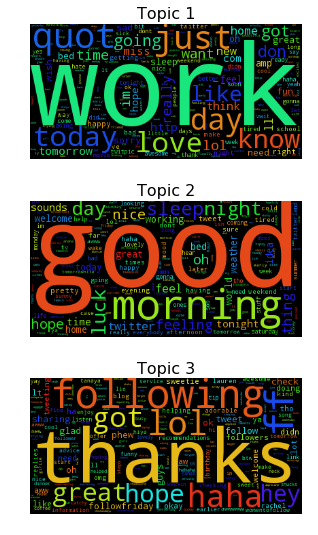

In [10]:
# import packages
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

# show plots inline
%matplotlib inline

# this function is used to generate plots for topics
def wdc(*mywords_topic):
    # size of each subplot is 3* 1.618 by 3
    n_row = len(mywords_topic)
    n_col = 1
    plt.figure(figsize = ( n_col * 3 * 1.618,  n_row * 3))    
    
    # call WordCloud
    wordcloud = WordCloud()
    
    # one plot per sorted topic
    i = 0
    for item in mywords_topic:
        wordcloud.fit_words(item)
        plt.subplot(n_row, n_col, i+1)
        plt.title('Topic %s' %str(i+1), size = 16)
        plt.imshow(wordcloud)
        plt.axis("off")
        i += 1

myarg = (mywords_topic1, mywords_topic2, mywords_topic3)

wdc(*myarg)

## 5 Discussion
For any new tweet, we first calculate its tf-idf matrix (**X**) and then calculate its **W** matrix. This will then allow us to assign the new tweet to a segment and predict its sentiment (e.g. positive sentiment vs negative sentiment on a product).

The following code shows how to calcuate the W matrix for new tweets that have been cleaned beforehand. For illustration purpose, these 5 tweets are the first 5 from the corpus used in the analysis.  

In [11]:
# prediction example
text_new = preprocessed[0:5]

# calculate tf-idf matrix
tfidf_new = vectorizer.transform(text_new)

# calculate W
W_new = nmf.transform(tfidf_new)